We will use the starter notebook to the Kaggle Competition as reference for our initial implementation

# Import Libraries 

In [1]:
import os
print(os.getcwd())

/home/jameslu3/Documents/bird-sound-detection


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-12-12 15:34:24.761993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 15:34:25.068301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734035665.207192  227529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734035665.248209  227529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 15:34:25.552563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch" 

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np 
import pandas as pd
from glob import glob
from tqdm import tqdm
import librosa
import IPython.display as ipd
import librosa.display as lid
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['coolwarm']

/home/jameslu3/Documents/bird-sound-detection/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import tensorflow as tf

# List all GPUs and enable memory growth for each GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled; dynamic GPU memory allocation requested.")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)


Memory growth enabled; dynamic GPU memory allocation requested.


## Library Version

In [5]:
import keras_cv
import keras
import keras.backend as K
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)


TensorFlow: 2.18.0
Keras: 3.7.0
KerasCV: 0.9.0


# Configuration 

You will need to change the paths to your local directories

In [81]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # For ResNet-LSTM model
    time_steps = 16
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset =  "efficientnetv2_b0_imagenet"
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir(r"data/birdclef-2024/train_audio")) # Change this  path
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Dataset Path 

In [11]:
df = pd.read_csv(f'data/birdclef-2024/train_metadata.csv')
df['filepath'] =  'data/birdclef-2024/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rows
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,data/birdclef-2024/train_audio/asbfly/XC134896...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,data/birdclef-2024/train_audio/asbfly/XC164848...,0,XC164848


## Utility

In [12]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


# Visualization:


/tmp/ipykernel_12269/888633304.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


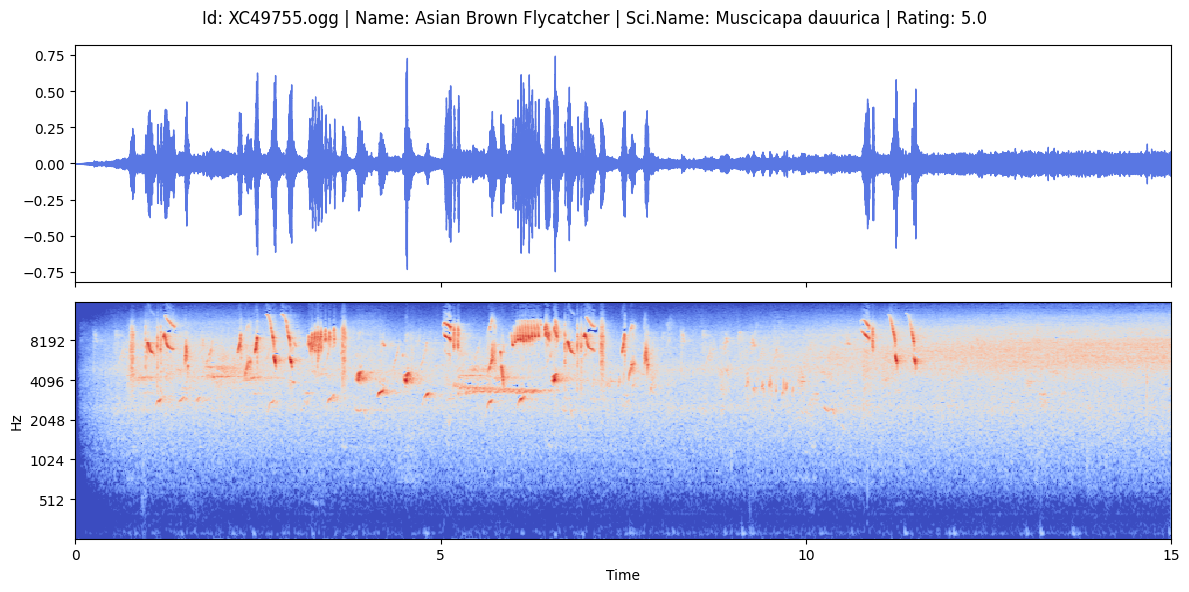

In [17]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Data Split  

Since we do not have access to the testing set, we will split training into two and treat validation set as test set initially

In [13]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


# Data Loader 

## Decoders

Here, we will take inspiration from other previous implementation regarding decoding .ogg files as they are good practices. For example, we will change from stereo to mono and standardize the length as well as generate mel spectograms with 3 channels to match ImageNet. Decoding is done using librosa package.


In [14]:
import librosa
import tensorflow as tf

def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _load_audio(path):
            # Convert the path tensor to a string
            path = tf.compat.as_str_any(path.numpy())
            # Load the audio file with librosa
            audio, _ = librosa.load(path, sr=CFG.sample_rate, mono=True)
            return audio

        # Use tf.py_function to execute _load_audio in eager mode
        audio = tf.py_function(_load_audio, [filepath], tf.float32)
        return tf.reshape(audio, [-1])  # Ensure it has a 1D shape

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim)
        
        # Compute Mel spectrogram with librosa
        def _compute_mel_spec(audio):
            mel_spec = librosa.feature.melspectrogram(
                y=audio.numpy(),
                sr=CFG.sample_rate,
                n_fft=CFG.nfft,
                hop_length=CFG.hop_length,
                n_mels=CFG.img_size[0]
            )
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            return mel_spec

        mel_spec = tf.py_function(_compute_mel_spec, [audio], tf.float32)
        mel_spec = apply_preproc(mel_spec)
        mel_spec = tf.tile(mel_spec[..., None], [1, 1, 3])
        mel_spec = tf.image.resize(mel_spec, CFG.img_size)
        return mel_spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode



## Augmenters
We will apply augmentations to spectrogram data by usingMixUp, CutOut (TimeMasking and FreqMasking in this case) from KerasCV for this initial implementation. We plan to experiment with other augmentation techniques later in the project but from looking at related work regarding CNNs, these seems to work the best and will be a good initial starting point to expriment with.

In [15]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                    width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                    width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

## Data Pipeline
We will use the tf.dataset package to build a datapipeline incorporating different paths to the audio files 

In [16]:
def split_timesteps(images, labels):
    batch = tf.shape(images)[0]
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    channels = tf.shape(images)[3]

    time = CFG.time_steps
    step_width = width // time
    images = tf.reshape(images, (batch, time, height, step_width, channels))
    return images, labels

def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048, timestep=None):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len) 

    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if timestep:
        ds = ds.map(split_timesteps, num_parallel_calls=AUTO)

    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Datasets

In [80]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Visualization 
Generate **spectrogram** and its associate **label** 

In [58]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

2024-12-12 14:11:12.811940: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


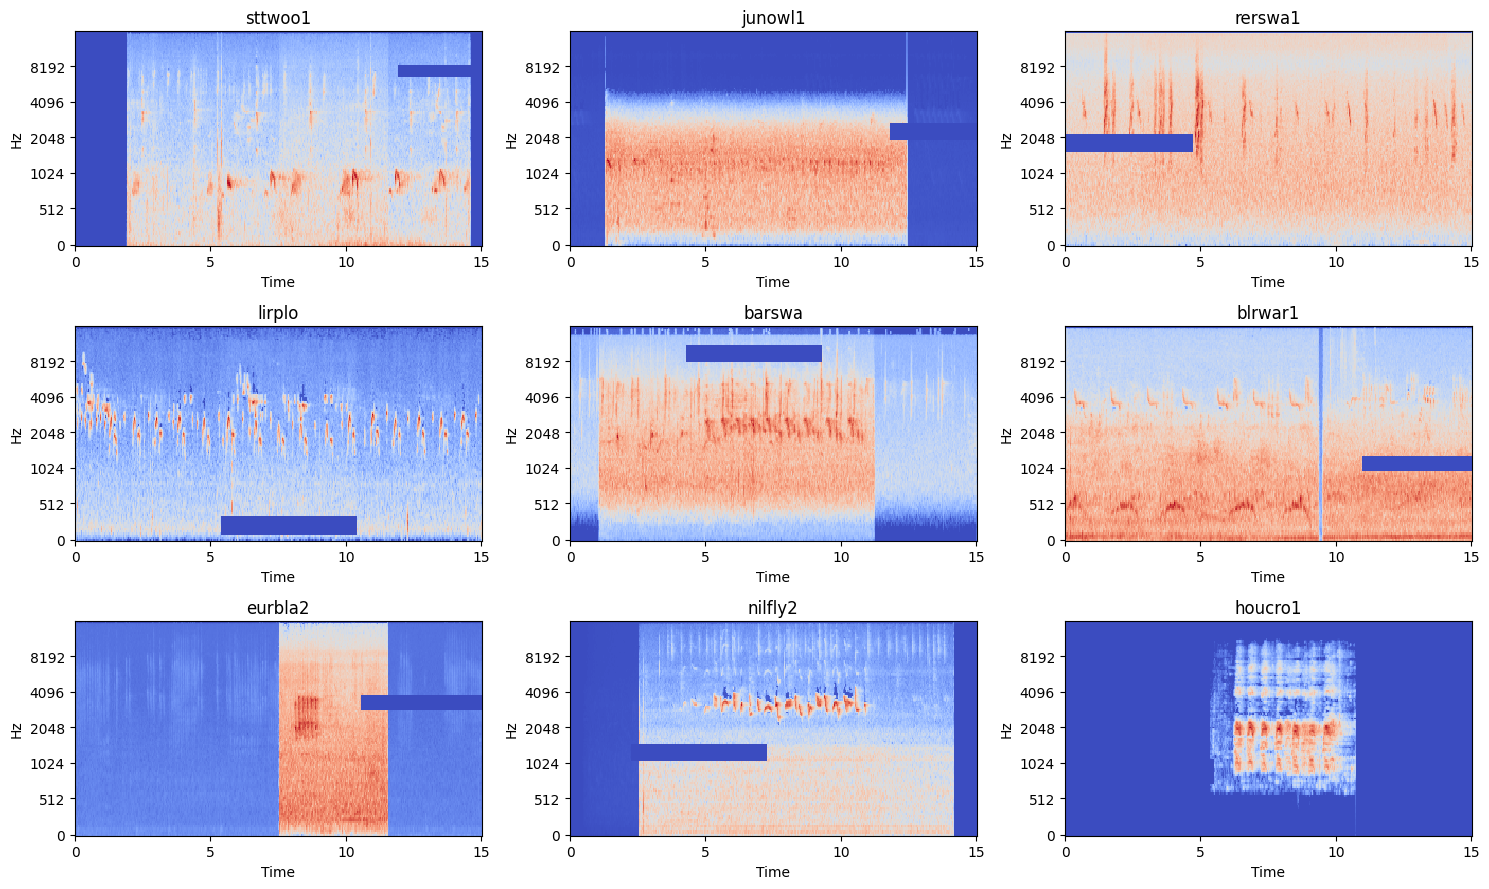

In [59]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

In [31]:
print(keras_cv.models.EfficientNetV2Backbone.presets)

{'efficientnetv2_s': {'metadata': {'description': 'EfficientNet architecture with 6 convolutional blocks.', 'params': 20331360, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_s/2'}, 'efficientnetv2_m': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks.', 'params': 53150388, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_m/2'}, 'efficientnetv2_l': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks, but more filters the in `efficientnetv2_m`.', 'params': 117746848, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_l/2'}, 'efficientnetv2_b0': {'metadata': {'description': 'EfficientNet B-style architecture with 6 convolutional blocks. This B-style model has `width_coefficient=1.0

## Build Train and Valid Datasets for ResNet-LSTM

In [17]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment, timestep=True)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False, timestep=True)

# Visualization 
Generate each timestep for example **spectrogram**  

In [55]:
def plot_time_steps(spectrogram, time_steps, label=None):
    """Plot one spectogram with multiple time steps"""
    n_cols = min(time_steps, 5) 
    n_rows = (time_steps + n_cols - 1) // n_cols 

    plt.figure(figsize=(n_cols * 5, n_rows * 3))  

    for t in range(time_steps):
        ax = plt.subplot(n_rows, n_cols, t + 1)
        step_spec = spectrogram[t, :, :, 0]
        
        librosa.display.specshow(
            step_spec,
            sr=CFG.sample_rate,
            hop_length=CFG.hop_length,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm'
        )
        plt.title(f"Time Step {t + 1}", fontsize=10)
    
    if label is not None:
        plt.suptitle(f"Label: {label}", fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.show()

2024-12-12 16:06:22.445883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


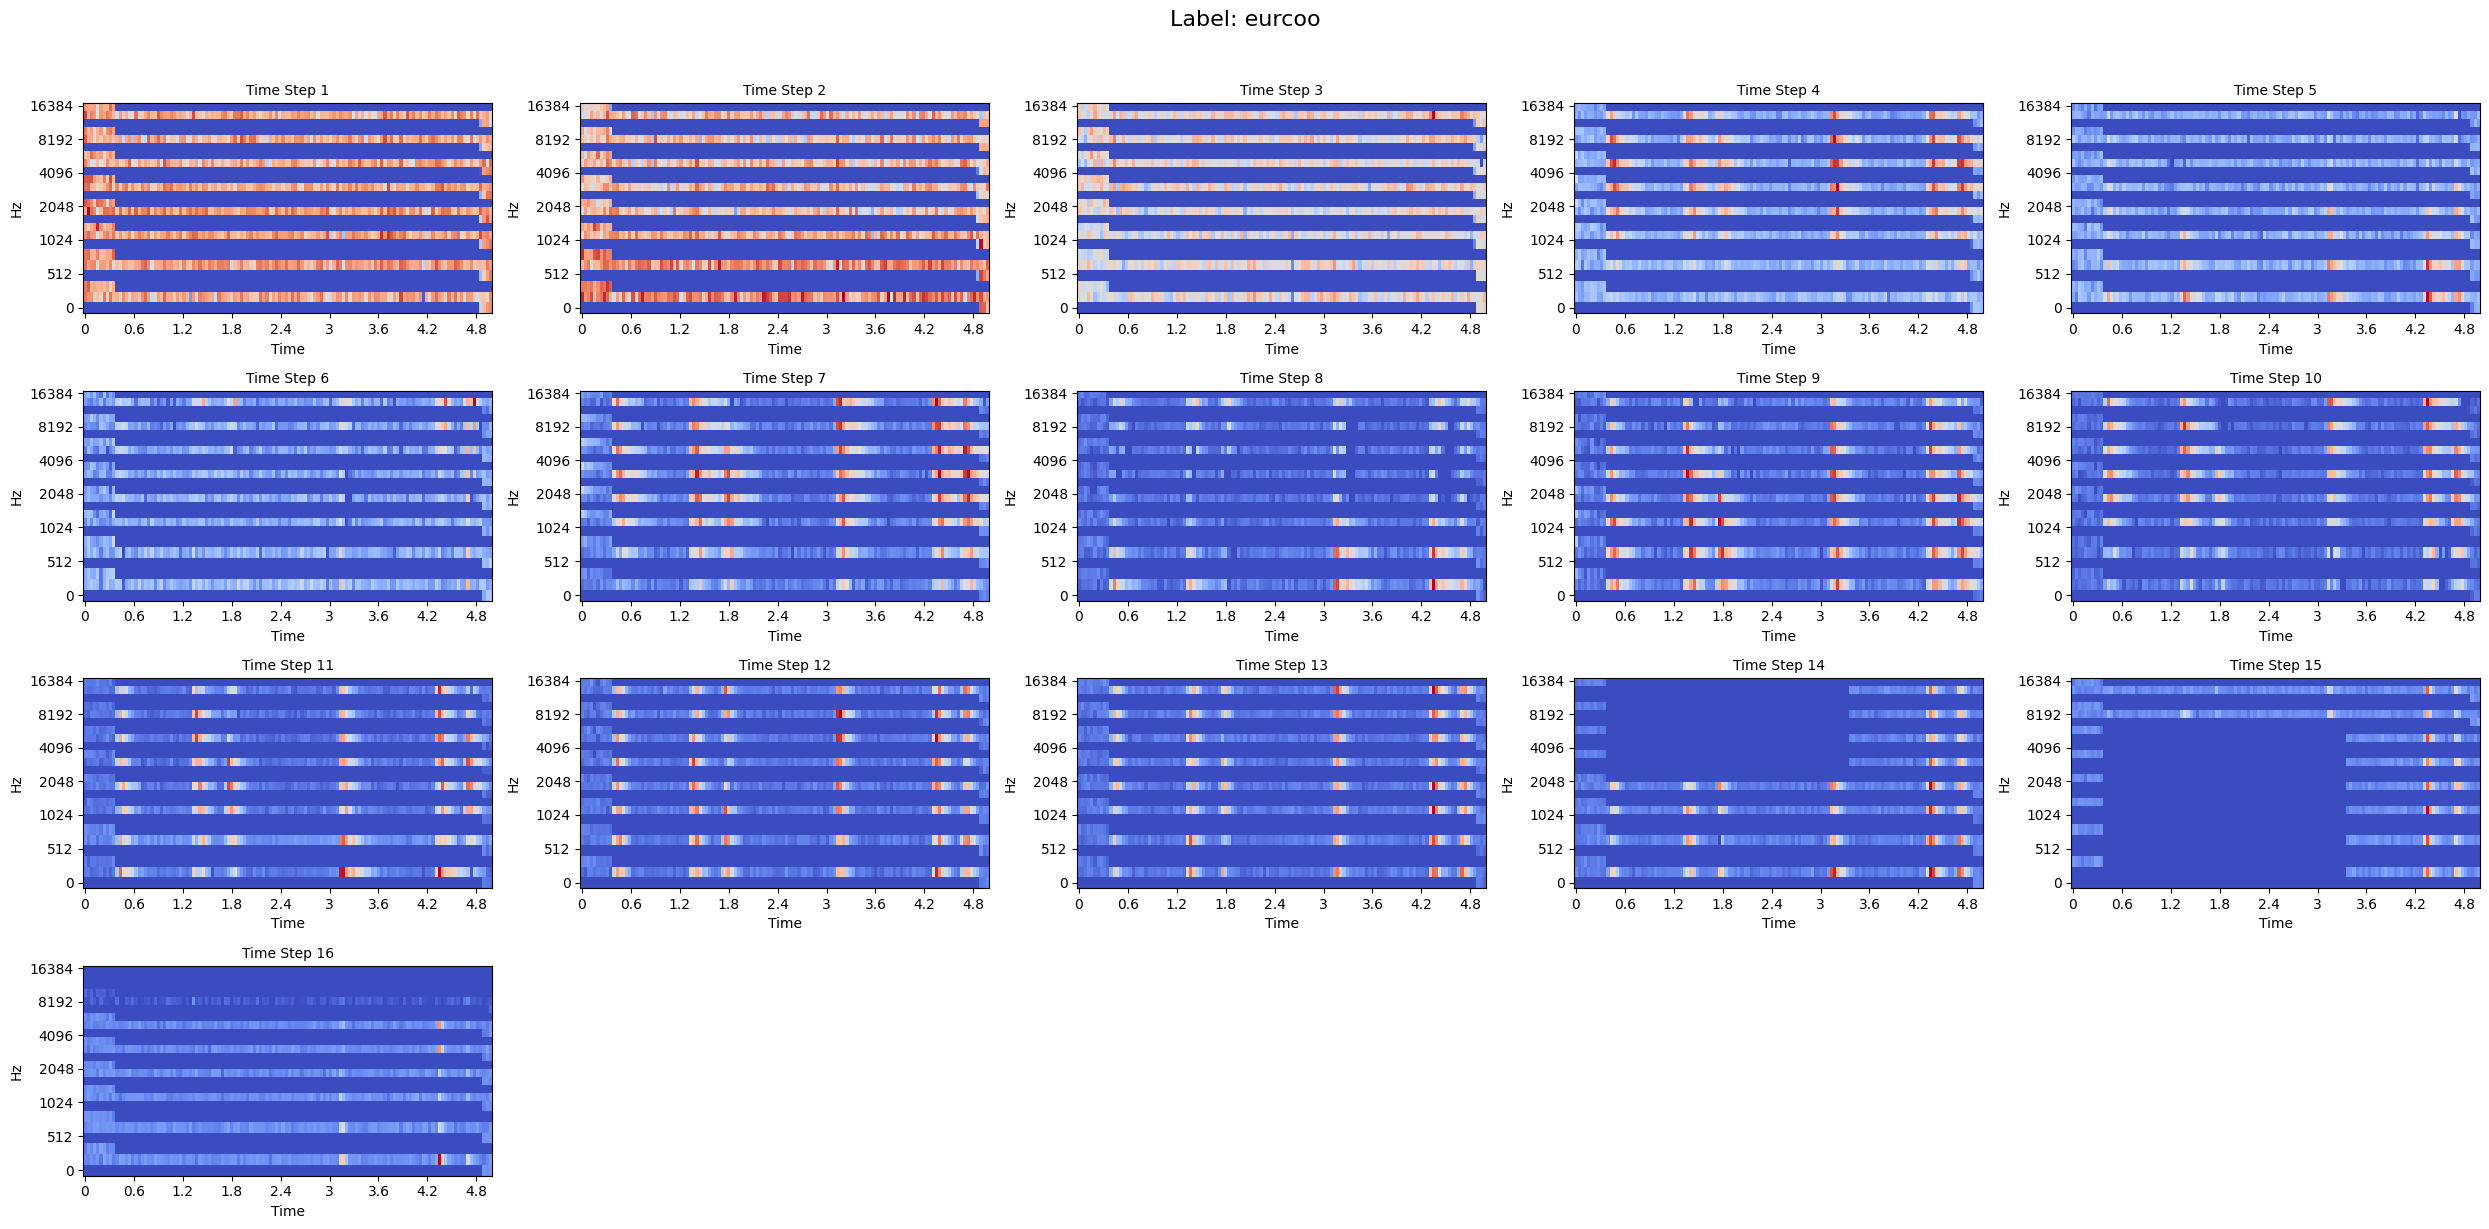

In [56]:
sample = next(iter(train_ds))
single_spec = sample[0][0] 
single_label = CFG.label2name[sample[1][0].numpy().argmax()]
reshaped_spec = tf.reshape(single_spec, [CFG.time_steps, CFG.img_size[1] // CFG.time_steps, CFG.img_size[0], 3])

# Plot the time steps
plot_time_steps(reshaped_spec.numpy(), CFG.time_steps, label=single_label)

# Build Models

To perform the audio recognition task, I will utilize the `EfficientNetV2` ImageNet-pretrained model as a base implementation and fine tune using our data. Even though EfficientNetV2 is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

 In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a large length .


In [32]:
from tensorflow import keras
import keras_cv

# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Load the pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)

# Stack custom layers on top of the backbone
x = backbone(inp, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
out = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')],
)

# Display the model summary
model.summary()


100%|██████████| 1.79k/1.79k [00:00<00:00, 2.75MB/s]


100%|██████████| 23.1M/23.1M [00:01<00:00, 21.4MB/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b0_backbone     │ (None, None, None,     │     5,919,312 │
│ (EfficientNetV2Backbone)        │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 182)            │       233,142 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,152,454 (23.47 MB)

 Trainable params: 6,091,846 (23.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

**Try training with ImageNet50 to compare and see if model size would have much impact** 

In [6]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # For ResNet-LSTM model
    time_steps = 16
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset =  "resnet50_imagenet"
    
    # Data augmentation parameters
    augment=True
    

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir(r"data/birdclef-2024/train_audio")) # Change this  path
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [7]:
from tensorflow import keras
import keras_cv

# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Load the ResNet50 backbone
backbone = keras_cv.models.ResNet50Backbone.from_preset(
    CFG.preset,
)

# Stack custom layers on top of the backbone
x = backbone(inp, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
out = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')],
)

# Display the model summary
model.summary()

I0000 00:00:1734035739.752020  227529 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net50_backbone              │ (None, None, None,     │    23,561,152 │
│ (ResNetBackbone)                │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 182)            │       372,918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,934,070 (91.30 MB)

 Trainable params: 23,880,950 (91.10 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Try a ResNet-LSTM architecture** 

In [10]:
import resnet_lstm
hybrid_model = resnet_lstm.create_resnet_lstm_model(CFG)

Shape before LSTM: (None, 16, 2048)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 384, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 12, 4,      │    23,561,152 │
│ (TimeDistributed)               │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 182)            │        46,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,968,246 (99.06 MB)

 Trainable params: 25,915,126 (98.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

# LR Schedule 
* Learning Rate scheduler for transfer learning. 

In [57]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 4e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 4, 0, 0.9

    def lrfn(epoch):  # Learning rate update 
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

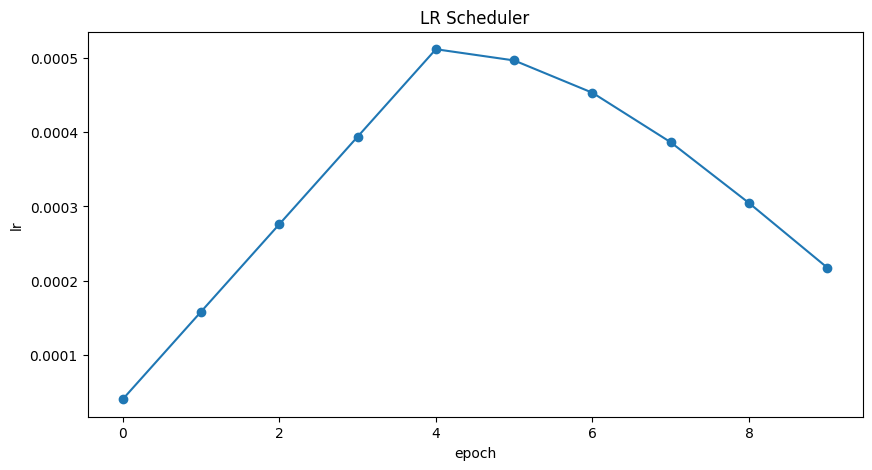

In [58]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

## Training using transfer learning

In [60]:
ckpt_cb = keras.callbacks.ModelCheckpoint("model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

In [61]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [62]:
import tensorflow as tf
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())


Is TensorFlow built with CUDA? True


In [63]:
import tensorflow as tf
# Run some warm-up iterations
for _ in range(5):
    _ = tf.random.uniform((1000, 1000)) @ tf.random.uniform((1000, 1000))


In [64]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [26]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import gc

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()
        gc.collect()

history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb, ClearMemory()], 
    verbose=1
)


Epoch 1/10


I0000 00:00:1733176954.077821   15800 service.cc:148] XLA service 0x7efbc4002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733176954.080038   15800 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2024-12-02 17:02:35.308198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733176974.291661   15800 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-02 17:03:00.011468: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17186', 312 bytes spill stores, 316 bytes spill loads

2024-12-02 17:03:00.053950: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc: 0.6116 - loss: 5.0601

2024-12-02 17:12:39.876215: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2444', 16 bytes spill stores, 16 bytes spill loads

2024-12-02 17:12:40.286046: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2444', 144 bytes spill stores, 144 bytes spill loads

2024-12-02 17:12:40.344742: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2444', 520 bytes spill stores, 520 bytes spill loads



305/305 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - auc: 0.6119 - loss: 5.0595 - val_auc: 0.7686 - val_loss: 4.6323 - learning_rate: 4.0000e-05
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - auc: 0.7733 - loss: 4.5334 - val_auc: 0.8877 - val_loss: 3.5927 - learning_rate: 1.5800e-04
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - auc: 0.8368 - loss: 3.4227 - val_auc: 0.9493 - val_loss: 2.2577 - learning_rate: 2.7600e-04
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - auc: 0.8653 - loss: 2.4759 - val_auc: 0.9605 - val_loss: 1.8289 - learning_rate: 3.9400e-04
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - auc: 0.8661 - loss: 2.0471 - val_auc: 0.9654 - val_loss: 1.6170 - learning_rate: 5.1200e-04
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - auc: 0.8997 - loss: 1.6328 - val_auc: 0.9662 - val_loss: 1.5003 - learning_rate: 4.9686e-04
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - auc: 0.8764 - loss: 1.5279 - val_auc: 0.9674 - val_loss: 1.4196 - le

In [ ]:
model.save_weights('model.weights.h5')

## Result Summary

In [59]:
best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
print('>>> Best AUC: ', best_score)
print('>>> Best Epoch: ', best_epoch+1)

NameError: name 'history' is not defined

In [ ]:
model.save("models")  # Choose a directory to save the model


## Let's try and visualize the output of one batch using t-SNE

In [ ]:

model.load_weights('model.weights.h5')
# load the mobilenet weights


In [49]:
from tensorflow.keras.models import Model

# Replace 'dense' with the actual name of your dense layer
dense_layer_name = 'dense'
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(dense_layer_name).output)


In [57]:
import numpy as np

# Number of batches to collect
num_batches = 64

# Initialize lists to store images and labels
all_images = []
all_labels = []

# Iterate through the dataset and collect batches
for i, batch in enumerate(valid_ds.take(num_batches)):
    batch_images, batch_labels = batch
    all_images.append(batch_images.numpy())  # Convert to numpy for easy manipulation
    all_labels.append(batch_labels.numpy())
    if i + 1 == num_batches:
        break

# Concatenate all batches into a single array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("All images shape:", all_images.shape)  # (batch_size * num_batches, ...)
print("All labels shape:", all_labels.shape)  # (batch_size * num_batches, ...)


All images shape: (4096, 128, 384, 3)
All labels shape: (4096, 182)


In [58]:
# Extract features for all collected images
features = feature_extractor.predict(all_images)
print("Features shape:", features.shape)  # (total_samples, num_features)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Features shape: (4096, 182)


In [60]:
from sklearn.manifold import TSNE

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)
print("t-SNE results shape:", tsne_results.shape)  # Shape: (batch_size, 2)


t-SNE results shape: (4096, 2)


In [61]:
print("Features shape:", features.shape)  # Shape: (batch_size, num_features)
print("Batch labels shape:", batch_labels.shape)  # Shape should match batch_size


Features shape: (4096, 182)
Batch labels shape: (64, 182)


In [62]:
# Convert one-hot labels to categorical if needed
all_labels = np.argmax(all_labels, axis=1)

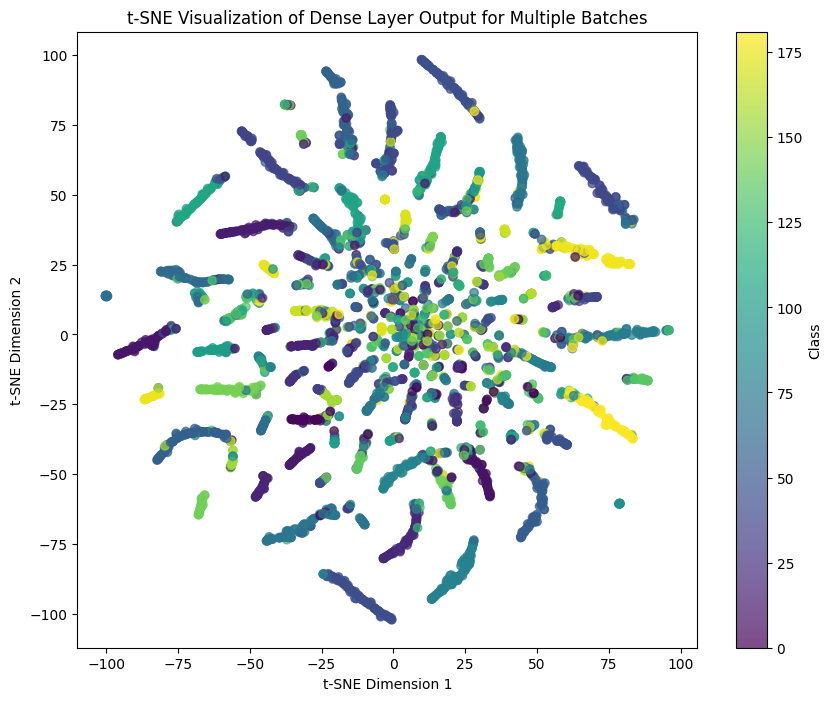

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_results = tsne.fit_transform(features)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Dense Layer Output for Multiple Batches")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


There seems to just simply be too many classes and data points to infer anything useful about the model's learned feature for each class. Let's simply try to visualize just 10 classes 

In [69]:
import numpy as np

# Specify the labels you want to visualize
desired_labels = [0, 1 ,2,3,4,5,6,7,8,9]

# Create a mask for the desired labels
mask = np.isin(all_labels, desired_labels)

# Filter features and labels based on the mask
filtered_features = features[mask]
filtered_labels = all_labels[mask]


In [72]:
# Perform t-SNE on the filtered features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(filtered_features)


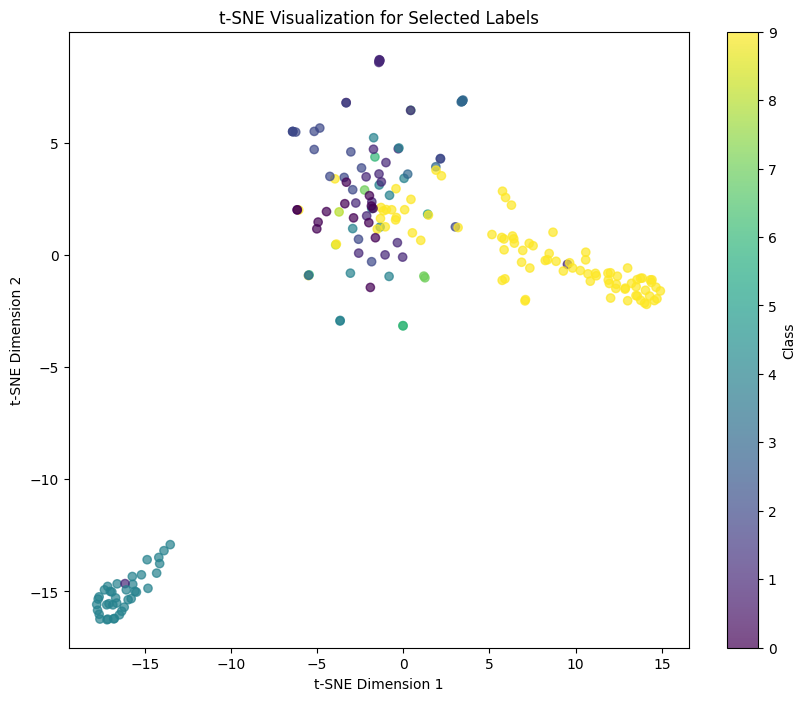

In [73]:
import matplotlib.pyplot as plt

# Visualize t-SNE results for the selected labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization for Selected Labels")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


NameError: name 'label2name' is not defined

Visualizing just 10 classes shows that the model is learning distinct features for class 5 and class 10. Here we can see distinctly the difference between class 10 and class 5 corresponds to .. and class 9 corresponds to the species... . Inspecting the sound file , we see that 